<a href="https://colab.research.google.com/github/kevinkhu/exoplanet_atmospheres/blob/main/Exoplanet_Archive_Atmospheric_Retrieval_with_PLATON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NASA Exoplanet Archive PLATON Atmospheric Retrieval
This notebook utilizes the PLanetary Atmospheric Transmission for Observer Noobs (PLATON) tool ([Zhang, M. et al., 2019](https://ui.adsabs.harvard.edu/abs/2019PASP..131c4501Z/abstract), [Zhang, M. et al., 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...899...27Z/abstract), [Source on Github](https://github.com/ideasrule/platon), [Documentation](https://platon.readthedocs.io)) for use with [Transmission Spectroscopy data](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=transitspec) from the Exoplanet Archive.

This notebook is meant to require minimal user input, unless you want to provide your own data. Each step will either begin with *(Play)* or **(Input)**. No editing is necessary for the *(Play)* steps, just hover over the cell and press the "Play" button on the left. The **(Input)** steps will tell you what can be changed.

1.   *(Play)* Install some dependencies and the PLATON package.



In [1]:
!apt-get install libopenblas-dev
!pip install git+https://github.com/ideasrule/platon.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libopenblas-dev is already the newest version (0.2.20+ds-4).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
  Cloning https://github.com/ideasrule/platon.git to /tmp/pip-req-build-pbaukj68
  Running command git clone -q https://github.com/ideasrule/platon.git /tmp/pip-req-build-pbaukj68
  Created wheel for platon: filename=platon-5.1.2-cp37-none-any.whl size=34388118 sha256=84d68949c296fad94470d2e78522865540c1c76e6965f9f56a663d0f6bd64eb3
  Stored in directory: /tmp/pip-ephem-wheel-cache-jyxg8dwi/wheels/b6/0a/a3/dbb59b64ca49dafbd9e93ac0ad990ae2c878627722ebe406db
Successfully built platon


2.   *(Play)* Import some packages!



In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import io
import requests

from platon.fit_info import FitInfo
from platon.combined_retriever import CombinedRetriever
from platon.constants import R_sun, R_jup, M_jup, R_earth, M_earth
print('Packages successfully imported!')

Packages successfully imported!


3.   *(Play)* Read in the [transmission spectroscopy table](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=transitspec) from the Exoplanet Archive and list the available planets.



In [4]:
url="https://www.dropbox.com/s/eteod7kpwpd95d8/transitspec_2021.04.08_11.45.14.csv?dl=1"
tstable=pd.read_csv(url, comment='#', header=0)

print('Here are all the available planets: ',tstable.plntname.unique())

Here are all the available planets:  ['WASP-12 b' 'HAT-P-1 b' 'CoRoT-1 b' 'GJ 436 b' 'GJ 1214 b' 'HAT-P-12 b'
 'HAT-P-16 b' 'HD 97658 b' 'WASP-6 b' 'WASP-17 b' 'WASP-43 b' 'WASP-39 b'
 'WASP-19 b' 'HD 189733 b' 'GJ 3470 b' 'HAT-P-32 b' 'TrES-2 b' 'TrES-4 b'
 'HD 209458 b' 'WASP-31 b' 'WASP-80 b' 'HAT-P-11 b' 'KOI-12 b' 'KOI-13 b'
 'Kepler-410 A b' 'Kepler-93 b' 'Kepler-20 c' 'Kepler-20 d' 'Kepler-10 c'
 'Kepler-102 e' 'Kepler-102 d' 'Kepler-19 b' 'Kepler-22 b' 'KOI-94 d'
 'Kepler-14 b' 'Kepler-94 b' 'Kepler-104 d' 'Kepler-18 c' 'Kepler-18 d'
 'Kepler-11 e' 'Kepler-25 c' 'Kepler-25 b' 'Kepler-37 d' 'Kepler-68 b'
 'Kepler-49 b' 'Kepler-49 c' 'Kepler-26 c' 'Kepler-125 b' 'Kepler-126 d'
 'Kepler-127 d' 'Kepler-138 c' 'Kepler-158 c' 'Kepler-205 c' 'Kepler-62 e'
 'Kepler-236 c' 'Kepler-249 d' 'Kepler-32 d' 'Kepler-61 b' 'WASP-29 b'
 'XO-1 b' 'XO-2 N b' 'HAT-P-23 b' 'WASP-48 b' 'WASP-14 b' '55 Cnc e'
 'WASP-45 b' 'WASP-46 b' 'WASP-57 b' 'HAT-P-26 b' 'K2-26 b' 'K2-3 b'
 'K2-3 c' 'K2-3 d' 'HAT-

4. **(Input)** Select your favorite planet from the list above.

In [35]:
planet = 'WASP-121 b' # Edit the name within the quotes. Make sure the exact string matches a planet in the list above.

if tstable['plntname'].str.contains(planet).any():
  print("You have selected planet "+planet)
else:
  print("Please check your planet name, it doesn't appear to be in the list above.")

You have selected planet WASP-121 b


5. *(Play)* Plot the data! Check that things look okay.

Text(0, 0.5, 'Planet radius/Star radius')

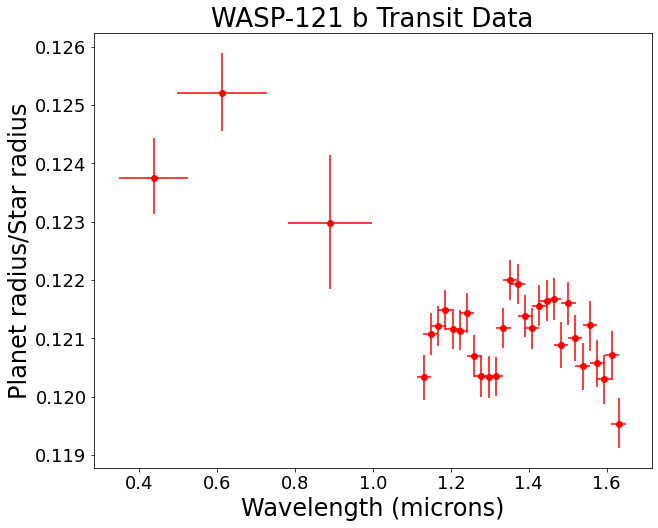

In [37]:
# Extract data from the table above for only the selected planet.
df = tstable.loc[(tstable['plntname'] == planet) & (tstable['centralwavelng'] > 0.3)] #This truncates the data to >0.3 microns, the limit of the models used below.
df = df.dropna(subset=['bandwidth', 'plnratror', 'plnratrorerr1', 'plnratrorerr2'])
df = df.reset_index(drop=True)

# Make the plot
plt.figure(figsize=(10,8))
plt.title(planet+' Transit Data', fontsize=26)
plt.errorbar(x=df.centralwavelng,y=df.plnratror,xerr=df.bandwidth,yerr=[df.plnratrorerr1,-df.plnratrorerr2],fmt='o',color='red')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Wavelength (microns)',fontsize=24)
plt.ylabel('Planet radius/Star radius',fontsize=24)

# plt.xscale('log') #uncomment if necessary


6. *(Play)* Download system parameter data from the Exoplanet Archive. 

In [11]:
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=compositepars"
syspars=pd.read_csv(url, comment='#', header=0)
plsyspars = syspars.loc[(syspars['fpl_name'] == planet)]
plsyspars = plsyspars.reset_index(drop=True)
plsyspars

,fpl_hostname,fpl_letter,fpl_name,fpl_discmethod,fpl_disc,fpl_controvflag,fpl_orbper,fpl_orbpererr1,fpl_orbpererr2,fpl_orbperlim,fpl_orbperreflink,fpl_smax,fpl_smaxerr1,fpl_smaxerr2,fpl_smaxlim,fpl_smaxreflink,fpl_eccen,fpl_eccenerr1,fpl_eccenerr2,fpl_eccenlim,fpl_eccenreflink,fpl_bmasse,fpl_bmasseerr1,fpl_bmasseerr2,fpl_bmasselim,fpl_bmassprov,fpl_bmassreflink,fpl_rade,fpl_radeerr1,fpl_radeerr2,fpl_radelim,fpl_radreflink,fpl_dens,fpl_denserr1,fpl_denserr2,fpl_denslim,fpl_densreflink,fpl_eqt,fpl_eqterr1,fpl_eqterr2,...,fst_nirmagreflink,fst_spt,fst_sptlim,fst_sptreflink,fst_teff,fst_tefferr1,fst_tefferr2,fst_tefflim,fst_teffreflink,fst_logg,fst_loggerr1,fst_loggerr2,fst_logglim,fst_loggreflink,fst_lum,fst_lumerr1,fst_lumerr2,fst_lumlim,fst_lumreflink,fst_mass,fst_masserr1,fst_masserr2,fst_masslim,fst_massreflink,fst_rad,fst_raderr1,fst_raderr2,fst_radlim,fst_radreflink,fst_met,fst_meterr1,fst_meterr2,fst_metlim,fst_metratio,fst_metreflink,fst_age,fst_ageerr1,fst_ageerr2,fst_agelim,fst_agereflink
0,HD 189733,b,HD 189733 b,Radial Velocity,2005,0,2.218576,1.500000e-07,-1.500000e-07,0.0,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,0.0313,0.0004,-0.0004,0.0,<a refstr=BOUCHY_ET_AL__2005 href=https://ui.a...,0.0,NaN,NaN,0.0,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,359.1479,25.4264,-25.4264,0.0,Mass,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,12.666,0.112,-0.112,0.0,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,0.943,0.024,-0.024,0.0,<a refstr=AGOL_ET_AL__2010 href=https://ui.ads...,1209.0,11.0,-11.0,...,<a refstr=2MASS_POINT_SOURCE_CATALOG href=http...,K2 V,0.0,<a refstr=GRAY_ET_AL__2003 href=https://ui.ads...,5052.0,16.0,-16.0,0.0,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,4.49,0.05,-0.05,0.0,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,-0.46,0.0,-0.0,0.0,<a refstr=GAIA_COLLABORATION_ET_AL__2018 href=...,0.79,0.08,-0.08,0.0,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,0.75,0.01,-0.01,0.0,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,-0.02,NaN,NaN,0.0,[Fe/H],<a refstr=STASSUN_ET_AL__2017 href=https://ui....,1.4,4.9,-1.9,0.0,<a refstr=SOUTHWORTH_2010 href=https://ui.adsa...


7. *(Play)* Take the basic planet and stellar parameters from the table above. Feel free to **(Input)** your own values if you have them.


In [23]:
#Planet Parameters
R_guess = plsyspars['fpl_rade'][0] * R_earth #Planet radius guess in Earth radii, if that wasn't obvious already
R_err = np.mean([np.abs(plsyspars['fpl_radeerr1'][0]),np.abs(plsyspars['fpl_radeerr2'][0])]) * R_earth #Planet radius error in Earth radii
print('Planet Parameters')
print('R_planet = '+str(round(R_guess/R_earth,2))+' \u00B1 '+str(round(R_err/R_earth,2))+' R_Earth = '+str(round(R_guess/R_jup,2))+' \u00B1 '+str(round(R_err/R_jup,2))+' R_Jupiter')

M_pl = plsyspars['fpl_bmasse'][0] * M_earth #Planet mass (or msini) in Earth masses
M_pl_err = np.mean([np.abs(plsyspars['fpl_bmasseerr1'][0]),np.abs(plsyspars['fpl_bmasseerr2'][0])]) * M_earth #Planet mass error in Earth masses
print('M_planet = '+str(round(M_pl/M_earth,2))+' \u00B1 '+str(round(M_pl_err/M_earth,2))+' M_Earth = '+str(round(M_pl/M_jup,2))+' \u00B1 '+str(round(M_pl_err/M_jup,2))+' M_Jupiter')

T_guess = plsyspars['fpl_eqt'][0] #Planet equilibrium temperature guess in Kelvin
print('T_eq = '+str(int(T_guess))+' K')

#Stellar Parameters
Rs = plsyspars['fst_rad'][0] * R_sun #Star radius in Sun radii
Rs_err = np.mean([np.abs(plsyspars['fst_raderr1'][0]),np.abs(plsyspars['fst_raderr2'][0])]) * R_sun #Star radius measurement error in Sun radii
print('\nStellar Parameters')
print('R_star = '+str(round(Rs/R_sun,2))+' \u00B1 '+str(round(Rs_err/R_sun,2))+' R_Sun')

T_star = plsyspars['fst_teff'][0] #Star effective temperature in Kelvin
print('T_eff = '+str(int(T_star))+' K')

Planet Parameters
R_planet = 12.67 ± 0.11 R_Earth = 1.13 ± 0.01 R_Jupiter
M_planet = 359.15 ± 25.43 M_Earth = 1.13 ± 0.08 M_Jupiter
T_eq = 1209 K

Stellar Parameters
R_star = 0.75 ± 0.01 R_Sun
T_eff = 5052 K


8. *(Play)* If you have values for planetary atmospheric metallicity (log Z) or the planetary C/O ratio, **(Input)** them below, otherwise leave them at the default values.

In [25]:
logZ_guess = 0 #Planetary atmospheric metallicity relative to the Sun. If you don't know this, set to 0.
CO_guess = 0.54 #Planetary C/O ratio. If you don't know this, set to 0.54 which is the solar value.
print('log(Z) = '+str(logZ_guess))
print('C/O = '+str(CO_guess))

log(Z) = 0
C/O = 0.54


9. *(Play)* *Run the PLATON retrieval!* This will run 1000 emcee steps and take ~**35 to 75 minutes** (typically depending on the amount of input data), so feel free to work on something else for about an hour... or if you're at home do yourself a favor and go bake some cookies! By the time the cookies are done, your code will have finished (probably), your place will smell like cookies, and, best of all, you'll have some cookies!

After all 1000 steps have run, the best fit results will print below and also save to a file *BestFit.txt* in the sample_data folder in the Files panel to the left.

In [31]:
#Convert the data input to arrays
def winputs():
  wave_bins = []
  depths = []
  errors = []
  for i in range(len(df)):
    wave_bins.append([df['centralwavelng'][i]-df['bandwidth'][i]/2,df['centralwavelng'][i]+df['bandwidth'][i]/2])
    depths.append((df['plnratror'][i])**2)
    errors.append((df['plnratrorerr1'][i])**2)
    # print(wave_bins,depths,errors)
  return 1e-6*np.array(wave_bins), np.array(depths), np.array(errors)

wbins, wdepths, werrors = winputs()
bins=wbins
depths=wdepths
errors=werrors

#create a Retriever object
retriever = CombinedRetriever()

#create a FitInfo object and set best guess parameters
fit_info = retriever.get_default_fit_info(
    Rs=Rs, Mp=M_pl, Rp=R_guess, T=T_guess,
    logZ=logZ_guess, CO_ratio=CO_guess, log_cloudtop_P=3,
    log_scatt_factor=0, scatt_slope=4, error_multiple=1, T_star=T_star)

#Add fitting parameters - this specifies which parameters you want to fit
#e.g. since we have not included cloudtop_P, it will be fixed at the value specified in the constructor

fit_info.add_gaussian_fit_param('Rs', Rs_err)
fit_info.add_gaussian_fit_param('Mp', M_pl_err)

# Here, emcee is initialized with walkers where R is between 0.9*R_guess and
# 1.1*R_guess.  However, the hard limit on R is from 0 to infinity.
fit_info.add_uniform_fit_param('Rp', 0, np.inf, 0.9*R_guess, 1.1*R_guess)

fit_info.add_uniform_fit_param('T', 1000, 3000, 0.5*T_guess, 1.5*T_guess)
fit_info.add_uniform_fit_param("log_scatt_factor", 0, 5, 0, 1)
fit_info.add_uniform_fit_param("logZ", -1, 3)
fit_info.add_uniform_fit_param("log_cloudtop_P", -0.99, 5)
fit_info.add_uniform_fit_param("error_multiple", 0, np.inf, 0.5, 5)

#Use Nested Sampling to do the fitting
result = retriever.run_emcee(bins, depths, errors,
                             None, None, None,
                             fit_info,
                             rad_method="xsec" #"ktables" for corr-k
)

with open("example_retrieval_result.pkl", "wb") as f:
    pickle.dump(result, f)

#Useful members: result.chain, result.lnprobability, result.flatchain, result.flatlnprobability

/usr/local/lib/python3.7/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Step 10: ln_prob=-1.98e+09	Rs=0.74 R_sun	Mp=1.08 M_jup	Rp=1.12 R_jup	T=1403 K	log_scatt_factor=0.71 	logZ=-0.56 	log_cloudtop_P=1.94 	error_multiple=3.54 	
Step 20: ln_prob=-6.89e+08	Rs=0.76 R_sun	Mp=1.21 M_jup	Rp=1.13 R_jup	T=1297 K	log_scatt_factor=0.70 	logZ=0.83 	log_cloudtop_P=1.44 	error_multiple=2.80 	
Step 30: ln_prob=-2.11e+08	Rs=0.74 R_sun	Mp=1.11 M_jup	Rp=1.10 R_jup	T=1534 K	log_scatt_factor=0.80 	logZ=-0.70 	log_cloudtop_P=2.28 	error_multiple=3.42 	
Step 40: ln_prob=-4.22e+08	Rs=0.76 R_sun	Mp=1.11 M_jup	Rp=1.13 R_jup	T=1747 K	log_scatt_factor=0.86 	logZ=1.54 	log_cloudtop_P=1.16 	error_multiple=3.90 	
Step 50: ln_prob=-1.15e+08	Rs=0.76 R_sun	Mp=1.15 M_jup	Rp=1.13 R_jup	T=1345 K	log_scatt_factor=0.78 	logZ=0.28 	log_cloudtop_P=2.14 	error_multiple=4.66 	
Step 60: ln_prob=-9.87e+07	Rs=0.75 R_sun	Mp=1.13 M_jup	Rp=1.11 R_jup	T=1580 K	log_scatt_factor=0.83 	logZ=-0.20 	log_cloudtop_P=1.76 	error_multiple=5.23 	
Step 70: ln_prob=-7.24e+07	Rs=0.76 R_sun	Mp=1.09 M_jup	Rp=1.15 R_ju

/usr/local/lib/python3.7/dist-packages/platon/_params.py:59: RuntimeWarning: divide by zero encountered in log
  return np.log(scipy.stats.norm.pdf(value, self.best_guess, self.std))


Step 200: ln_prob=-1.89e+06	Rs=0.62 R_sun	Mp=2.42 M_jup	Rp=0.93 R_jup	T=1143 K	log_scatt_factor=2.43 	logZ=-0.82 	log_cloudtop_P=1.46 	error_multiple=41.57 	
Step 210: ln_prob=-2.58e+06	Rs=0.66 R_sun	Mp=2.43 M_jup	Rp=0.99 R_jup	T=1041 K	log_scatt_factor=1.88 	logZ=-0.31 	log_cloudtop_P=-0.86 	error_multiple=41.43 	
Step 220: ln_prob=-1.49e+06	Rs=0.71 R_sun	Mp=1.87 M_jup	Rp=1.08 R_jup	T=1340 K	log_scatt_factor=1.35 	logZ=-0.57 	log_cloudtop_P=3.60 	error_multiple=31.95 	
Step 230: ln_prob=-1.12e+06	Rs=0.71 R_sun	Mp=1.83 M_jup	Rp=1.07 R_jup	T=1372 K	log_scatt_factor=1.41 	logZ=-0.76 	log_cloudtop_P=4.36 	error_multiple=32.10 	
Step 240: ln_prob=-1.66e+06	Rs=0.74 R_sun	Mp=2.25 M_jup	Rp=1.12 R_jup	T=1280 K	log_scatt_factor=1.35 	logZ=0.46 	log_cloudtop_P=2.91 	error_multiple=42.26 	
Step 250: ln_prob=-1.01e+06	Rs=0.74 R_sun	Mp=2.05 M_jup	Rp=1.11 R_jup	T=1356 K	log_scatt_factor=1.51 	logZ=-0.26 	log_cloudtop_P=4.04 	error_multiple=38.98 	
Step 260: ln_prob=-8.71e+05	Rs=0.73 R_sun	Mp=1.87 M_

10. *(Play)* Plot your data and best fit retrieved spectrum. This will also save a file called *planet name*_best_fit.png in the sample_data folder to the left.


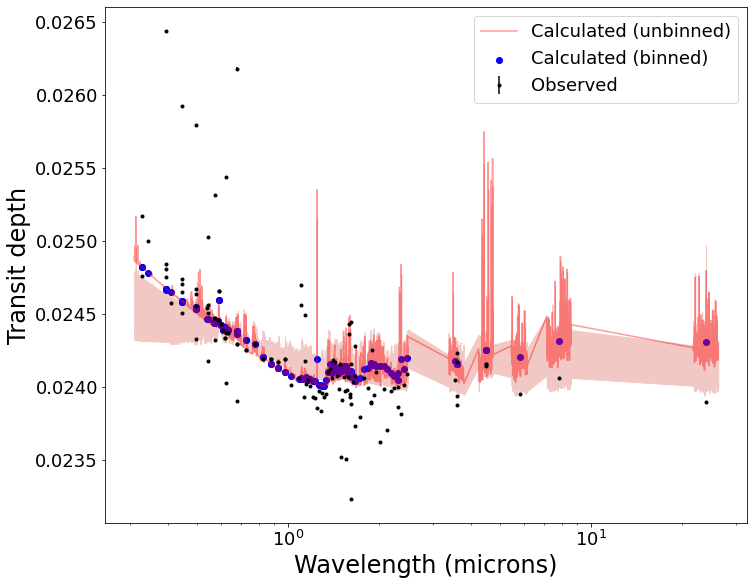

In [34]:
plt.figure(figsize=(10,8))
result.plot_spectrum(planet+"_best_fit")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Wavelength (microns)',fontsize=24)
plt.ylabel('Transit depth',fontsize=24)
#plt.xscale('linear') #uncomment as needed
plt.legend(fontsize='18')

11. *(Play)* Plot the 2D posteriors from the atmospheric retrieval. This will also save a file called *planet name*_emcee_corner.png in the sample_data folder to the left.

<Figure size 432x288 with 0 Axes>

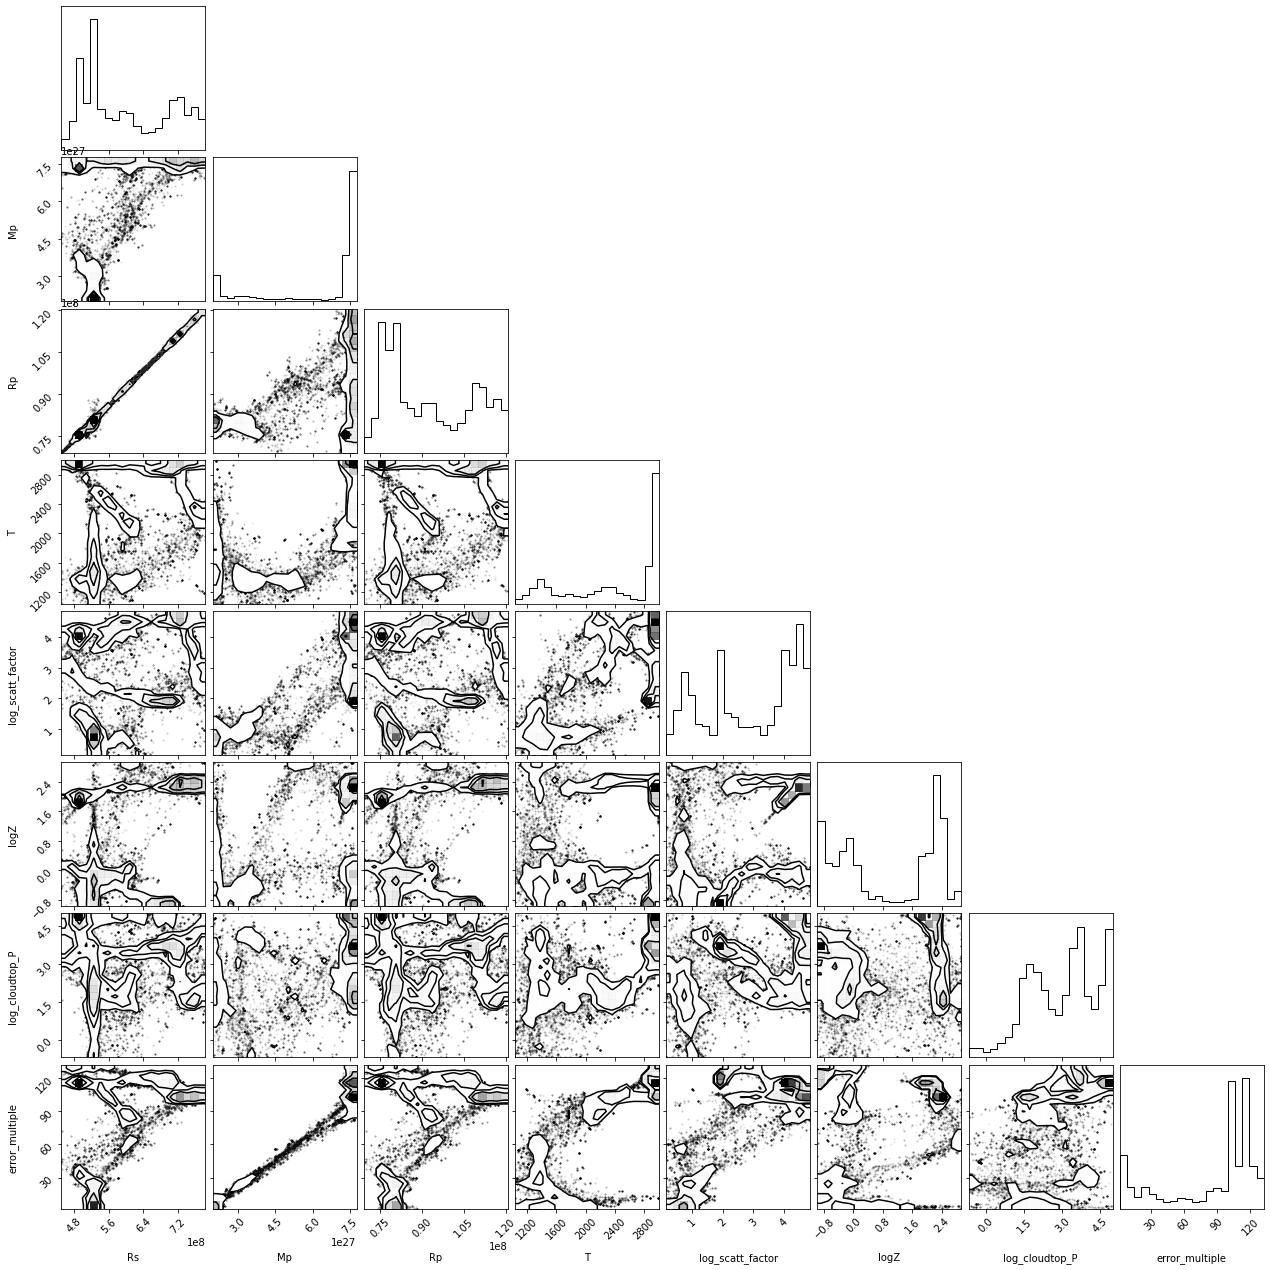

In [33]:
result.plot_corner(planet+"_emcee_corner.png")

You have reached the end of this tutorial, congratulations!